TODO: LOGGER

In [2]:
import pennylane as qml
from pennylane import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

from time import time

# Data

## \ -> 1
## / -> -1

In [3]:
# 100 '\' -> 1
# 100 '/' -> -1

import pickle

# data = []

# s = 15
# for i in range(100):
#     r = np.random.randint(4, 7, size=(2))/10
#     a = r[0].numpy()
#     b = r[1].numpy()
    # im = np.array([
    #                 [a,a/s],
    #                 [b/s,b]
    #                 ])
    # im = np.array([
    #                 [a/s,a],
    #                 [b,b/s]
    #                 ])
    # im = np.array([
    #                 [a/s,a],
    #                 [b/s,b]
    #                 ])
    # im = np.array([
    #                 [a,a/s],
    #                 [b,b/s]
    #                 ])
    # data.append(im)

# pickle.dump(np.array(data), open("generated_data.p", "wb"))

# label = np.append(np.zeros(100)+1, np.zeros(100)-1)
# pickle.dump(label.numpy(), open("generated_label.p", "wb"))

In [4]:
dataset = pickle.load(open("generated_data.p", "rb"))
labelset = pickle.load(open("generated_label.p", "rb"))

shuffler = np.random.permutation(200)
dataset = dataset[shuffler]
labelset = labelset[shuffler]

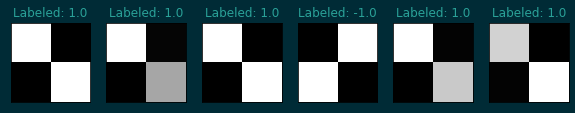

In [28]:
n_samples_show = 6

fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images = dataset[n_samples_show]
    targets = labelset[n_samples_show]

    axes[n_samples_show - 1].imshow(images, cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets))
    
    n_samples_show -= 1

## MNIST

In [3]:
data_root = '/home/hades/Documents/quantum_computing/Qcnn/data/MNIST_original/'
train_root = data_root + 'mnist_train.csv'
test_root = data_root + 'mnist_test.csv'

train_data_df = pd.read_csv(train_root, index_col=0)
test_data_df = pd.read_csv(test_root, index_col=0)
train_data = np.array(train_data_df)
test_data = np.array(test_data_df)

train_lables = np.array(train_data_df.index)
test_lables = np.array(test_data_df.index)

idx_0_train = np.where(train_lables == 0)[0]
idx_1_train = np.where(train_lables == 1)[0]

n_samples = 200
binary_train_data = np.vstack([train_data[idx_0_train][:n_samples], train_data[idx_1_train][:n_samples]])
binary_train_label = np.append(np.zeros(200), np.zeros(200)+1)

shuffler = np.random.permutation(2*n_samples)
binary_train_data = binary_train_data[shuffler]
binary_train_label = binary_train_label[shuffler]

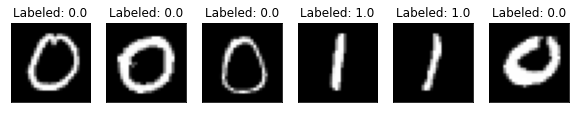

In [13]:
n_samples_show = 6

fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images = binary_train_data[n_samples_show].reshape(28,28)
    targets = binary_train_label[n_samples_show]

    axes[n_samples_show - 1].imshow(images, cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

# Qkernel

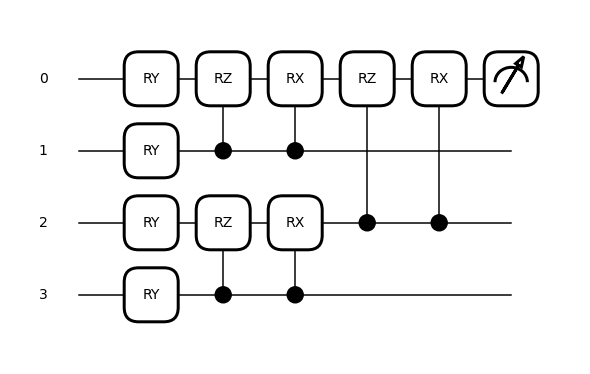

In [16]:
#make a 7qubit device
dev = qml.device("lightning.gpu", wires=4)

#inverce MERA
#configure circuit in a qnode using dev
@qml.qnode(dev)
def circuit(d, p):

    qml.RY(d[0], wires=0)
    qml.RY(d[1], wires=1)
    qml.RY(d[2], wires=2)
    qml.RY(d[3], wires=3)
    
    qml.CRZ(p[0],wires=(1,0))
    qml.CRX(p[1],wires=(1,0))
    
    qml.CRZ(p[2],wires=(3,2))
    qml.CRX(p[3],wires=(3,2))
    
    qml.CRZ(p[4],wires=(2,0))
    qml.CRX(p[5],wires=(2,0))

    return qml.expval(qml.PauliZ(0))

#define hyper_parameters and weights-init
np.random.seed(1)
random_trash_data = np.random.rand(4, requires_grad=True)
weights_init = 0.01 * np.random.randn(6, requires_grad=True)

#needs weights_inits hyperparameter
qml.drawer.use_style(style="solarized_dark")
fig, ax = qml.draw_mpl(circuit)(random_trash_data, weights_init)

## cost function

In [31]:
def cost(d, p, l):
    j = circuit(d.reshape(1,-1)[0], p) - l
    return abs(j)

## gradient

گرادیان رو برای لیست دوم ورودی تابع هزینمون تعریف می‌کنیم

In [32]:
dcircuit = qml.grad(cost, argnum=[1])

گرادیان خودمون رو هم تعریف می‌کنیم

مشکلش اینه که هنوز دیتای هوک شده و اینارو بهش اضافه نکردیم!

In [ ]:
class grader_optimizer:
    def __init__(
        self,
        qnode,
        in_params,
        cost,
        gradient,
        lr = 00.1) -> None:
        
        self.qnode = qnode
        self.params = in_params
        self.cost = cost
        self.gradient = gradient
        self.lr = lr

    def step(self):
        parameter_gradient = self.gradient(self.cost, self.params)
        new_parameter = self.params.numpy() - self.lr*parameter_gradient
        
        return new_parameter

    def train(self, step):
        for i in range(step):
            new_params = self.step()
            self.params = new_params
            if i+1%5 == 0 :
                cost = self.cost(self.params)
                print(
                    "cost after {} updates: {}".format(i, cost)
                )
        return self.params

In [ ]:
grader_optim = grader_optimizer(
    circuit,
    weights_init,
    cost,
    grader,
    0.1
)

# Trainer

In [33]:
class optimizer:
    def __init__(
        self,
        dataset,
        lables,
        qnode,
        in_params, # initial learnable parameters
        cost,
        gradient,
        lr = 00.1) -> None:

        self.dataset = dataset
        self.labels = lables
        # -> use this:
        self.qnode = qnode
        self.params = in_params
        # -> use this:
        self.cost = cost
        self.gradient = gradient
        self.lr = lr

# TODO: convolv?
    def step(self, data_batch, label_batch):
        batch_params = []
        for data, label in zip(data_batch, label_batch):
            parameter_gradient = np.array(self.gradient(data.reshape(1,-1)[0], self.params, label))
            new_parameter = np.array(self.params) - self.lr*parameter_gradient
            batch_params.append(new_parameter)
        batch_params = sum(batch_params)/len(batch_params)
        return batch_params

    def train(self, epoach, iterations):
        data_batches = np.split(self.dataset, iterations)
        label_batches = np.split(self.labels, iterations)
        for i in range(epoach):
            for data_batch, label_batch in zip(data_batches, label_batches):
                new_params = self.step(data_batch, label_batch)
                self.params = new_params[0]
        return self.params

In [50]:
optim = optimizer(
    dataset,
    labelset,
    circuit,
    weights_init,
    cost,
    dcircuit,
    1.5
)

## Train

In [ ]:
# ress = []
# plt.plot(ress)
# for i in range(50):
#     ress.append(circuit(optim.train(100, 20)))
#     print(sum(ress)/len(ress), "after" ,i+1, "it")
#     plt.plot(ress)
# print(sum(ress)/len(ress))
# plt.plot(ress)

In [35]:
def coster(datas, parameters, labels):
    cost_list = []
    for d, l in zip(datas,labels):
        cost_list.append(cost(d, parameters, l))
    return sum(cost_list)/len(cost_list)

1 th params:
thats cost:
1.1276531647145096
2 th params:
thats cost:
1.1275314362976878
3 th params:
thats cost:
1.12669428494324
4 th params:
thats cost:
1.1212264420538174
5 th params:
thats cost:
1.0948529628622574
6 th params:
thats cost:
1.0453134167242195
7 th params:
thats cost:
1.017529577791318
8 th params:
thats cost:
1.0095795592815917
9 th params:
thats cost:
1.0077035477534082
10 th params:
thats cost:
1.0072798899183522
11 th params:
thats cost:
1.0071851317761191
12 th params:
thats cost:
1.007163980739209
13 th params:
thats cost:
1.0071592626429213
14 th params:
thats cost:
1.007158211005609
15 th params:
thats cost:
1.007157976845777
1.0480792563566694


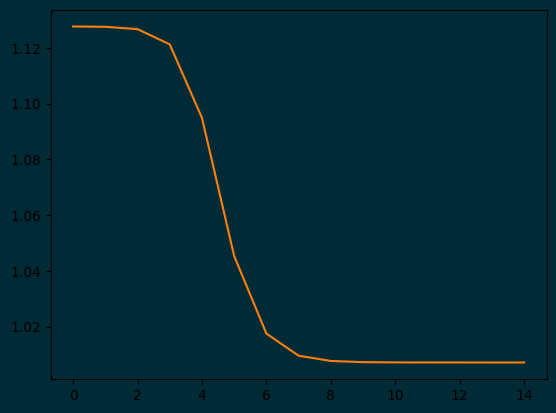

In [49]:
train_costs = []
plt.plot(train_costs)
for i in range(15):
    print('{} th'.format(i+1))
    time0 = time()
    it_params = optim.train(10, 20)
    time1 = time()
    print("takes {} seconds".format(time1-time0))
    print("thats cost:")
    train_costs.append(coster(dataset[:50], it_params, labelset[:50]))
    print(train_costs[-1])
print(sum(train_costs)/len(train_costs))
plt.plot(train_costs)

### test

In [67]:
circuit(dataset[11].reshape(1,-1)[0], optim.params)

tensor(0.99943958, requires_grad=True)

In [63]:
labelset[11]

-1.0

In [70]:
acc = 0
for d, l in zip(dataset, labelset):
    per = circuit(d.reshape(1,-1)[0], optim.params)
    if per>0.9 and l==-1:
        acc += 1/200
    elif per<0.9 and l==1:
        acc += 1/200
print(acc*100, "%")

79.00000000000006 %


In [ ]:
dcircuit(optim.train(step=20))

In [ ]:
dcircuit(random_trash_data, weights_init)